In [2]:
from NID.datasets import Pinky40
from NID.models import DnCNN
from NID.utils import weights_init_kaiming, batch_PSNR

import numpy as np
import scipy.io as sio 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataclasses import dataclass

import os
import h5py
import random
import cv2
import torch 
import torch.nn as nn 
import torch.optim as optim
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tensorboardX import SummaryWriter 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

@dataclass
class training_configurations: 
    '''class for storing options of the netowrk training'''
    preprocess: bool = False  
    batchSize: int = 256    # training batch size 
    num_of_layers: int = 17 # number of total layers 
    epochs: int = 3   #number of training epochs 
    milestone: int = 1 # when to decay learning rate 
    lr: float = 1e-3  # initial learning rate 
    outf: str = 'logs' #path of log files 
    mode: str = 'S' #with known noise level (S) or blind training (B)
    noiseL: float = 0.1 # noise level
    val_noiseL: float = 0.2 # nosie level used on validation set 

# prepare data

In [3]:
dataset_train = Pinky40(train=True, patch=29)
print(type(dataset_train))
dataset_val = Pinky40(train=False)
loader_train = DataLoader(dataset=dataset_train, num_workers=4, 
                         batch_size=256, shuffle=True)
print("# of training samples: %d\n" % len(dataset_train))
print("# of testing samples: %d\n" % len(dataset_val))

<class 'NID.datasets.Pinky40'>
# of training samples: 194581

# of testing samples: 311



# configure training options

In [12]:
opt = training_configurations()

# build model 

In [9]:
net = DnCNN(channels=1, num_of_layers=opt.num_of_layers)
# Move to GPU
device_ids = [0]
#initialize weights
# file_results = os.path.join(opt.outf, 'net_{}_state0.pth'.format(opt.num_of_layers))

# if os.path.exists(file_results):
#     print('use the trained model as the initialization')
#     model = nn.DataParallel(net, device_ids=device_ids).cuda()
#     model.load_state_dict(torch.load(file_results))
#     model.eval()
# else:
print("start from scratch to initialize the model")
net.apply(weights_init_kaiming)
if len(device_ids)==1: 
    device = torch.device('cuda:0')
    model = net.to(device)
else: 
    model = nn.DataParallel(net, device_ids=device_ids).cuda()

criterion = nn.MSELoss(reduction='sum')
criterion.cuda()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=opt.lr)
# training
writer = SummaryWriter(opt.outf)
step = 0
# opt.lr = 1e-4

start from scratch to initialize the model


# start training - GPU

In [13]:
output_file = os.path.join(opt.outf, 'pinky40_net_{}.pth'.format(opt.num_of_layers))
train_again = False 

if os.path.exists(output_file) and (not train_again): 
    # load the saved model directly 
    model.load_state_dict(torch.load(output_file))
else: 
    # train the model again 
    for epoch in range(opt.epochs):
        # reduce the learning rate after opt.milestone iterations
        if epoch < opt.milestone:
            current_lr = opt.lr
        else:
            current_lr = opt.lr / 10.

        # set learning rate
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        print('epoch %d: learning rate %f' % (epoch, current_lr))
        
        # train
        for i, data in enumerate(loader_train, 0):
            # training step
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            img_train = data
            
            # generate noisy images 
            if opt.mode == 'S':
                noise = torch.FloatTensor(img_train.size()).normal_(mean=0, std=opt.noiseL)
            if opt.mode == 'B':
                noise = torch.zeros(img_train.size())
                stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise.size()[0])
                for n in range(noise.size()[0]):
                    sizeN = noise[0,:,:,:].size()
                    noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n])
            imgn_train = img_train + noise
            img_train, imgn_train = Variable(img_train.cuda()), Variable(imgn_train.cuda())
            noise = Variable(noise.cuda())
            
            # define the model output
            out_train = model(imgn_train)
            
            # define the objective function 
            loss = criterion(out_train, noise) / (imgn_train.size()[0]*2)
            
            # update model parameters using back-propagation 
            loss.backward()
            optimizer.step()
            
            # results
            model.eval()
            out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
            psnr_train = batch_PSNR(out_train, img_train, 1.)
            print("[epoch %d][%d/%d] loss: %.4f PSNR_train: %.4f" %
                (epoch+1, i+1, len(loader_train), loss.item(), psnr_train))
            # if you are using older version of PyTorch, you may need to change loss.item() to loss.data[0]
            
            if step % 100 == 0:
                # Log the scalar values
                writer.add_scalar('loss', loss.item(), step)
                writer.add_scalar('PSNR on training data', psnr_train, step)
            step += 1
            
        # evaluate the model using the test data 
        model.eval()

        psnr_val = 0
        for k in range(len(dataset_val)):
            img_val = torch.unsqueeze(dataset_val[k], 0)
            noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
            imgn_val = img_val + noise
            img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
            out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
            psnr_val += batch_PSNR(out_val, img_val, 1.)
        psnr_val /= len(dataset_val)
        print("\n[epoch %d] PSNR_val: %.4f" % (epoch+1, psnr_val))
        writer.add_scalar('PSNR on validation data', psnr_val, epoch)

        # save model
        torch.save(model.state_dict(), output_file)


epoch 0: learning rate 0.001000
[epoch 1][1/761] loss: 4.5212 PSNR_train: 22.5518
[epoch 1][2/761] loss: 4.2973 PSNR_train: 22.4220
[epoch 1][3/761] loss: 4.0911 PSNR_train: 22.2773
[epoch 1][4/761] loss: 3.8184 PSNR_train: 22.1890
[epoch 1][5/761] loss: 3.4424 PSNR_train: 22.1207
[epoch 1][6/761] loss: 3.0815 PSNR_train: 22.0742
[epoch 1][7/761] loss: 2.7053 PSNR_train: 22.0800
[epoch 1][8/761] loss: 2.3373 PSNR_train: 22.0556
[epoch 1][9/761] loss: 2.0333 PSNR_train: 22.0712
[epoch 1][10/761] loss: 1.7894 PSNR_train: 22.0927
[epoch 1][11/761] loss: 1.6249 PSNR_train: 22.0054
[epoch 1][12/761] loss: 1.4391 PSNR_train: 22.0419
[epoch 1][13/761] loss: 1.2873 PSNR_train: 22.0137
[epoch 1][14/761] loss: 1.1779 PSNR_train: 21.9561
[epoch 1][15/761] loss: 1.1276 PSNR_train: 21.8763
[epoch 1][16/761] loss: 1.0794 PSNR_train: 21.8415
[epoch 1][17/761] loss: 0.9941 PSNR_train: 21.8808
[epoch 1][18/761] loss: 0.9076 PSNR_train: 21.9027
[epoch 1][19/761] loss: 0.8768 PSNR_train: 21.9284
[epoch 1

[epoch 1][162/761] loss: 0.1755 PSNR_train: 34.8303
[epoch 1][163/761] loss: 0.1794 PSNR_train: 34.5159
[epoch 1][164/761] loss: 0.1809 PSNR_train: 34.6063
[epoch 1][165/761] loss: 0.1752 PSNR_train: 35.0155
[epoch 1][166/761] loss: 0.1812 PSNR_train: 34.8262
[epoch 1][167/761] loss: 0.1886 PSNR_train: 34.4386
[epoch 1][168/761] loss: 0.1638 PSNR_train: 34.8363
[epoch 1][169/761] loss: 0.1898 PSNR_train: 34.0471
[epoch 1][170/761] loss: 0.1773 PSNR_train: 34.3698
[epoch 1][171/761] loss: 0.1820 PSNR_train: 34.2335
[epoch 1][172/761] loss: 0.1737 PSNR_train: 34.4581
[epoch 1][173/761] loss: 0.1819 PSNR_train: 34.0979
[epoch 1][174/761] loss: 0.1660 PSNR_train: 34.5470
[epoch 1][175/761] loss: 0.1874 PSNR_train: 34.5852
[epoch 1][176/761] loss: 0.1839 PSNR_train: 34.4439
[epoch 1][177/761] loss: 0.1915 PSNR_train: 33.7097
[epoch 1][178/761] loss: 0.1656 PSNR_train: 34.0346
[epoch 1][179/761] loss: 0.1840 PSNR_train: 33.8423
[epoch 1][180/761] loss: 0.1775 PSNR_train: 33.9347
[epoch 1][18

[epoch 1][321/761] loss: 0.1491 PSNR_train: 35.4411
[epoch 1][322/761] loss: 0.1531 PSNR_train: 35.7189
[epoch 1][323/761] loss: 0.1640 PSNR_train: 35.2332
[epoch 1][324/761] loss: 0.1607 PSNR_train: 34.9635
[epoch 1][325/761] loss: 0.1628 PSNR_train: 34.8990
[epoch 1][326/761] loss: 0.1597 PSNR_train: 34.8762
[epoch 1][327/761] loss: 0.1600 PSNR_train: 35.0989
[epoch 1][328/761] loss: 0.1491 PSNR_train: 35.6895
[epoch 1][329/761] loss: 0.1529 PSNR_train: 35.2611
[epoch 1][330/761] loss: 0.1598 PSNR_train: 35.2021
[epoch 1][331/761] loss: 0.1580 PSNR_train: 35.2160
[epoch 1][332/761] loss: 0.1560 PSNR_train: 34.6419
[epoch 1][333/761] loss: 0.1493 PSNR_train: 35.2326
[epoch 1][334/761] loss: 0.1463 PSNR_train: 35.5066
[epoch 1][335/761] loss: 0.1482 PSNR_train: 34.9968
[epoch 1][336/761] loss: 0.1528 PSNR_train: 34.8259
[epoch 1][337/761] loss: 0.1504 PSNR_train: 35.3428
[epoch 1][338/761] loss: 0.1518 PSNR_train: 34.9574
[epoch 1][339/761] loss: 0.1659 PSNR_train: 34.6709
[epoch 1][34

[epoch 1][479/761] loss: 0.1530 PSNR_train: 34.8913
[epoch 1][480/761] loss: 0.1387 PSNR_train: 36.1004
[epoch 1][481/761] loss: 0.1468 PSNR_train: 35.4940
[epoch 1][482/761] loss: 0.1372 PSNR_train: 35.2174
[epoch 1][483/761] loss: 0.1694 PSNR_train: 35.1825
[epoch 1][484/761] loss: 0.1441 PSNR_train: 35.9686
[epoch 1][485/761] loss: 0.1523 PSNR_train: 35.7188
[epoch 1][486/761] loss: 0.1472 PSNR_train: 35.6670
[epoch 1][487/761] loss: 0.1459 PSNR_train: 35.4758
[epoch 1][488/761] loss: 0.1386 PSNR_train: 35.9458
[epoch 1][489/761] loss: 0.1370 PSNR_train: 36.3985
[epoch 1][490/761] loss: 0.1535 PSNR_train: 35.4612
[epoch 1][491/761] loss: 0.1466 PSNR_train: 35.5496
[epoch 1][492/761] loss: 0.1454 PSNR_train: 36.0170
[epoch 1][493/761] loss: 0.1485 PSNR_train: 35.7734
[epoch 1][494/761] loss: 0.1397 PSNR_train: 35.2842
[epoch 1][495/761] loss: 0.1550 PSNR_train: 35.7046
[epoch 1][496/761] loss: 0.1459 PSNR_train: 36.1499
[epoch 1][497/761] loss: 0.1442 PSNR_train: 35.9570
[epoch 1][49

[epoch 1][637/761] loss: 0.1433 PSNR_train: 35.3691
[epoch 1][638/761] loss: 0.1412 PSNR_train: 35.3332
[epoch 1][639/761] loss: 0.1459 PSNR_train: 35.7278
[epoch 1][640/761] loss: 0.1442 PSNR_train: 36.0757
[epoch 1][641/761] loss: 0.1446 PSNR_train: 36.0898
[epoch 1][642/761] loss: 0.1443 PSNR_train: 36.4095
[epoch 1][643/761] loss: 0.1404 PSNR_train: 36.3236
[epoch 1][644/761] loss: 0.1534 PSNR_train: 35.8765
[epoch 1][645/761] loss: 0.1456 PSNR_train: 35.8544
[epoch 1][646/761] loss: 0.1402 PSNR_train: 36.2030
[epoch 1][647/761] loss: 0.1357 PSNR_train: 36.1166
[epoch 1][648/761] loss: 0.1411 PSNR_train: 35.1674
[epoch 1][649/761] loss: 0.1346 PSNR_train: 36.2288
[epoch 1][650/761] loss: 0.1413 PSNR_train: 35.9964
[epoch 1][651/761] loss: 0.1519 PSNR_train: 35.6037
[epoch 1][652/761] loss: 0.1364 PSNR_train: 35.8944
[epoch 1][653/761] loss: 0.1415 PSNR_train: 35.8314
[epoch 1][654/761] loss: 0.1436 PSNR_train: 36.0330
[epoch 1][655/761] loss: 0.1446 PSNR_train: 35.7565
[epoch 1][65

[epoch 2][34/761] loss: 0.1489 PSNR_train: 35.8650
[epoch 2][35/761] loss: 0.1329 PSNR_train: 36.5102
[epoch 2][36/761] loss: 0.1439 PSNR_train: 36.0520
[epoch 2][37/761] loss: 0.1299 PSNR_train: 36.6102
[epoch 2][38/761] loss: 0.1336 PSNR_train: 36.2366
[epoch 2][39/761] loss: 0.1388 PSNR_train: 36.1561
[epoch 2][40/761] loss: 0.1247 PSNR_train: 36.2421
[epoch 2][41/761] loss: 0.1411 PSNR_train: 36.0775
[epoch 2][42/761] loss: 0.1182 PSNR_train: 36.7889
[epoch 2][43/761] loss: 0.1387 PSNR_train: 36.1862
[epoch 2][44/761] loss: 0.1371 PSNR_train: 36.2663
[epoch 2][45/761] loss: 0.1388 PSNR_train: 36.0821
[epoch 2][46/761] loss: 0.1427 PSNR_train: 35.9964
[epoch 2][47/761] loss: 0.1346 PSNR_train: 36.3426
[epoch 2][48/761] loss: 0.1362 PSNR_train: 36.2195
[epoch 2][49/761] loss: 0.1453 PSNR_train: 35.9372
[epoch 2][50/761] loss: 0.1315 PSNR_train: 36.2077
[epoch 2][51/761] loss: 0.1417 PSNR_train: 36.0429
[epoch 2][52/761] loss: 0.1349 PSNR_train: 36.2410
[epoch 2][53/761] loss: 0.1366 

[epoch 2][193/761] loss: 0.1303 PSNR_train: 36.2942
[epoch 2][194/761] loss: 0.1281 PSNR_train: 36.3237
[epoch 2][195/761] loss: 0.1315 PSNR_train: 36.4837
[epoch 2][196/761] loss: 0.1264 PSNR_train: 36.4523
[epoch 2][197/761] loss: 0.1437 PSNR_train: 35.9826
[epoch 2][198/761] loss: 0.1465 PSNR_train: 35.9510
[epoch 2][199/761] loss: 0.1364 PSNR_train: 36.1895
[epoch 2][200/761] loss: 0.1470 PSNR_train: 35.8429
[epoch 2][201/761] loss: 0.1341 PSNR_train: 36.1387
[epoch 2][202/761] loss: 0.1377 PSNR_train: 36.0834
[epoch 2][203/761] loss: 0.1303 PSNR_train: 36.2675
[epoch 2][204/761] loss: 0.1351 PSNR_train: 36.2792
[epoch 2][205/761] loss: 0.1373 PSNR_train: 36.1912
[epoch 2][206/761] loss: 0.1357 PSNR_train: 36.3142
[epoch 2][207/761] loss: 0.1290 PSNR_train: 36.3651
[epoch 2][208/761] loss: 0.1345 PSNR_train: 36.2731
[epoch 2][209/761] loss: 0.1328 PSNR_train: 36.3418
[epoch 2][210/761] loss: 0.1392 PSNR_train: 36.1403
[epoch 2][211/761] loss: 0.1302 PSNR_train: 36.3814
[epoch 2][21

[epoch 2][351/761] loss: 0.1317 PSNR_train: 36.5298
[epoch 2][352/761] loss: 0.1286 PSNR_train: 36.4700
[epoch 2][353/761] loss: 0.1362 PSNR_train: 36.1619
[epoch 2][354/761] loss: 0.1319 PSNR_train: 36.1624
[epoch 2][355/761] loss: 0.1345 PSNR_train: 36.3334
[epoch 2][356/761] loss: 0.1355 PSNR_train: 36.1613
[epoch 2][357/761] loss: 0.1373 PSNR_train: 36.2012
[epoch 2][358/761] loss: 0.1275 PSNR_train: 36.6543
[epoch 2][359/761] loss: 0.1441 PSNR_train: 36.0743
[epoch 2][360/761] loss: 0.1356 PSNR_train: 36.4777
[epoch 2][361/761] loss: 0.1306 PSNR_train: 36.4660
[epoch 2][362/761] loss: 0.1541 PSNR_train: 35.7797
[epoch 2][363/761] loss: 0.1463 PSNR_train: 35.8953
[epoch 2][364/761] loss: 0.1340 PSNR_train: 36.3889
[epoch 2][365/761] loss: 0.1386 PSNR_train: 36.0611
[epoch 2][366/761] loss: 0.1284 PSNR_train: 36.4815
[epoch 2][367/761] loss: 0.1296 PSNR_train: 36.4306
[epoch 2][368/761] loss: 0.1374 PSNR_train: 36.0147
[epoch 2][369/761] loss: 0.1375 PSNR_train: 36.3179
[epoch 2][37

[epoch 2][510/761] loss: 0.1304 PSNR_train: 36.4222
[epoch 2][511/761] loss: 0.1247 PSNR_train: 36.5814
[epoch 2][512/761] loss: 0.1287 PSNR_train: 36.5131
[epoch 2][513/761] loss: 0.1253 PSNR_train: 36.7224
[epoch 2][514/761] loss: 0.1349 PSNR_train: 36.3319
[epoch 2][515/761] loss: 0.1338 PSNR_train: 36.2399
[epoch 2][516/761] loss: 0.1349 PSNR_train: 36.2849
[epoch 2][517/761] loss: 0.1267 PSNR_train: 36.7619
[epoch 2][518/761] loss: 0.1347 PSNR_train: 36.3880
[epoch 2][519/761] loss: 0.1428 PSNR_train: 35.9862
[epoch 2][520/761] loss: 0.1408 PSNR_train: 36.1562
[epoch 2][521/761] loss: 0.1257 PSNR_train: 36.7423
[epoch 2][522/761] loss: 0.1371 PSNR_train: 36.3744
[epoch 2][523/761] loss: 0.1360 PSNR_train: 36.3716
[epoch 2][524/761] loss: 0.1408 PSNR_train: 36.1194
[epoch 2][525/761] loss: 0.1229 PSNR_train: 36.5539
[epoch 2][526/761] loss: 0.1360 PSNR_train: 36.1963
[epoch 2][527/761] loss: 0.1396 PSNR_train: 36.3651
[epoch 2][528/761] loss: 0.1395 PSNR_train: 36.0272
[epoch 2][52

[epoch 2][668/761] loss: 0.1261 PSNR_train: 36.5823
[epoch 2][669/761] loss: 0.1297 PSNR_train: 36.3187
[epoch 2][670/761] loss: 0.1302 PSNR_train: 36.4517
[epoch 2][671/761] loss: 0.1391 PSNR_train: 36.0538
[epoch 2][672/761] loss: 0.1308 PSNR_train: 36.2738
[epoch 2][673/761] loss: 0.1347 PSNR_train: 36.2222
[epoch 2][674/761] loss: 0.1359 PSNR_train: 36.1272
[epoch 2][675/761] loss: 0.1266 PSNR_train: 36.3876
[epoch 2][676/761] loss: 0.1344 PSNR_train: 36.3990
[epoch 2][677/761] loss: 0.1291 PSNR_train: 36.3397
[epoch 2][678/761] loss: 0.1372 PSNR_train: 36.3813
[epoch 2][679/761] loss: 0.1304 PSNR_train: 36.7622
[epoch 2][680/761] loss: 0.1395 PSNR_train: 36.4087
[epoch 2][681/761] loss: 0.1417 PSNR_train: 36.1808
[epoch 2][682/761] loss: 0.1487 PSNR_train: 36.1896
[epoch 2][683/761] loss: 0.1356 PSNR_train: 36.4014
[epoch 2][684/761] loss: 0.1358 PSNR_train: 36.1869
[epoch 2][685/761] loss: 0.1294 PSNR_train: 36.3430
[epoch 2][686/761] loss: 0.1402 PSNR_train: 36.0395
[epoch 2][68

[epoch 3][65/761] loss: 0.1341 PSNR_train: 36.2778
[epoch 3][66/761] loss: 0.1391 PSNR_train: 36.1371
[epoch 3][67/761] loss: 0.1453 PSNR_train: 35.9509
[epoch 3][68/761] loss: 0.1341 PSNR_train: 36.2937
[epoch 3][69/761] loss: 0.1380 PSNR_train: 36.2352
[epoch 3][70/761] loss: 0.1250 PSNR_train: 36.7941
[epoch 3][71/761] loss: 0.1342 PSNR_train: 36.1962
[epoch 3][72/761] loss: 0.1223 PSNR_train: 36.7676
[epoch 3][73/761] loss: 0.1316 PSNR_train: 36.2659
[epoch 3][74/761] loss: 0.1464 PSNR_train: 35.9321
[epoch 3][75/761] loss: 0.1332 PSNR_train: 36.3339
[epoch 3][76/761] loss: 0.1375 PSNR_train: 36.0520
[epoch 3][77/761] loss: 0.1311 PSNR_train: 36.3031
[epoch 3][78/761] loss: 0.1344 PSNR_train: 35.8064
[epoch 3][79/761] loss: 0.1335 PSNR_train: 36.1391
[epoch 3][80/761] loss: 0.1292 PSNR_train: 36.3689
[epoch 3][81/761] loss: 0.1292 PSNR_train: 36.3422
[epoch 3][82/761] loss: 0.1400 PSNR_train: 36.1953
[epoch 3][83/761] loss: 0.1345 PSNR_train: 36.3536
[epoch 3][84/761] loss: 0.1307 

[epoch 3][224/761] loss: 0.1205 PSNR_train: 36.8022
[epoch 3][225/761] loss: 0.1348 PSNR_train: 36.3620
[epoch 3][226/761] loss: 0.1279 PSNR_train: 36.6323
[epoch 3][227/761] loss: 0.1390 PSNR_train: 36.3882
[epoch 3][228/761] loss: 0.1278 PSNR_train: 36.5374
[epoch 3][229/761] loss: 0.1394 PSNR_train: 36.1342
[epoch 3][230/761] loss: 0.1291 PSNR_train: 36.4759
[epoch 3][231/761] loss: 0.1370 PSNR_train: 36.2329
[epoch 3][232/761] loss: 0.1333 PSNR_train: 36.3999
[epoch 3][233/761] loss: 0.1296 PSNR_train: 36.3756
[epoch 3][234/761] loss: 0.1313 PSNR_train: 36.3930
[epoch 3][235/761] loss: 0.1240 PSNR_train: 36.7675
[epoch 3][236/761] loss: 0.1336 PSNR_train: 36.1984
[epoch 3][237/761] loss: 0.1306 PSNR_train: 36.4368
[epoch 3][238/761] loss: 0.1285 PSNR_train: 36.5245
[epoch 3][239/761] loss: 0.1292 PSNR_train: 36.4735
[epoch 3][240/761] loss: 0.1254 PSNR_train: 36.7184
[epoch 3][241/761] loss: 0.1358 PSNR_train: 36.2874
[epoch 3][242/761] loss: 0.1232 PSNR_train: 36.7847
[epoch 3][24

[epoch 3][382/761] loss: 0.1359 PSNR_train: 36.3212
[epoch 3][383/761] loss: 0.1310 PSNR_train: 36.3518
[epoch 3][384/761] loss: 0.1184 PSNR_train: 36.7924
[epoch 3][385/761] loss: 0.1421 PSNR_train: 35.9605
[epoch 3][386/761] loss: 0.1314 PSNR_train: 36.1717
[epoch 3][387/761] loss: 0.1320 PSNR_train: 36.1085
[epoch 3][388/761] loss: 0.1341 PSNR_train: 36.1471
[epoch 3][389/761] loss: 0.1318 PSNR_train: 36.0402
[epoch 3][390/761] loss: 0.1361 PSNR_train: 35.9306
[epoch 3][391/761] loss: 0.1317 PSNR_train: 36.1111
[epoch 3][392/761] loss: 0.1459 PSNR_train: 36.2243
[epoch 3][393/761] loss: 0.1305 PSNR_train: 36.3655
[epoch 3][394/761] loss: 0.1302 PSNR_train: 36.5898
[epoch 3][395/761] loss: 0.1310 PSNR_train: 36.6804
[epoch 3][396/761] loss: 0.1452 PSNR_train: 36.1035
[epoch 3][397/761] loss: 0.1307 PSNR_train: 36.5413
[epoch 3][398/761] loss: 0.1381 PSNR_train: 36.2116
[epoch 3][399/761] loss: 0.1315 PSNR_train: 36.3119
[epoch 3][400/761] loss: 0.1339 PSNR_train: 36.2523
[epoch 3][40

[epoch 3][540/761] loss: 0.1231 PSNR_train: 36.7837
[epoch 3][541/761] loss: 0.1370 PSNR_train: 36.2169
[epoch 3][542/761] loss: 0.1374 PSNR_train: 36.2569
[epoch 3][543/761] loss: 0.1407 PSNR_train: 36.1956
[epoch 3][544/761] loss: 0.1336 PSNR_train: 36.3735
[epoch 3][545/761] loss: 0.1320 PSNR_train: 36.5933
[epoch 3][546/761] loss: 0.1371 PSNR_train: 36.1490
[epoch 3][547/761] loss: 0.1335 PSNR_train: 36.1408
[epoch 3][548/761] loss: 0.1308 PSNR_train: 36.3358
[epoch 3][549/761] loss: 0.1286 PSNR_train: 36.3570
[epoch 3][550/761] loss: 0.1251 PSNR_train: 36.6697
[epoch 3][551/761] loss: 0.1304 PSNR_train: 36.6232
[epoch 3][552/761] loss: 0.1317 PSNR_train: 36.4910
[epoch 3][553/761] loss: 0.1349 PSNR_train: 36.5786
[epoch 3][554/761] loss: 0.1313 PSNR_train: 36.4737
[epoch 3][555/761] loss: 0.1300 PSNR_train: 36.5277
[epoch 3][556/761] loss: 0.1312 PSNR_train: 36.3486
[epoch 3][557/761] loss: 0.1254 PSNR_train: 36.6482
[epoch 3][558/761] loss: 0.1411 PSNR_train: 36.1634
[epoch 3][55

[epoch 3][698/761] loss: 0.1364 PSNR_train: 36.3645
[epoch 3][699/761] loss: 0.1302 PSNR_train: 36.8096
[epoch 3][700/761] loss: 0.1271 PSNR_train: 36.6158
[epoch 3][701/761] loss: 0.1310 PSNR_train: 36.5411
[epoch 3][702/761] loss: 0.1401 PSNR_train: 36.0459
[epoch 3][703/761] loss: 0.1310 PSNR_train: 36.5027
[epoch 3][704/761] loss: 0.1401 PSNR_train: 36.1859
[epoch 3][705/761] loss: 0.1189 PSNR_train: 36.8755
[epoch 3][706/761] loss: 0.1338 PSNR_train: 36.4504
[epoch 3][707/761] loss: 0.1434 PSNR_train: 36.0123
[epoch 3][708/761] loss: 0.1276 PSNR_train: 36.4943
[epoch 3][709/761] loss: 0.1400 PSNR_train: 36.1221
[epoch 3][710/761] loss: 0.1391 PSNR_train: 36.0996
[epoch 3][711/761] loss: 0.1338 PSNR_train: 36.2180
[epoch 3][712/761] loss: 0.1246 PSNR_train: 36.6221
[epoch 3][713/761] loss: 0.1260 PSNR_train: 36.6848
[epoch 3][714/761] loss: 0.1355 PSNR_train: 36.4592
[epoch 3][715/761] loss: 0.1349 PSNR_train: 36.2308
[epoch 3][716/761] loss: 0.1292 PSNR_train: 36.6102
[epoch 3][71

# import the model to ONNX format 

In [55]:
dummy_input = torch.randn(1, 1, 60, 80, device='cuda')
file_onnx = os.path.join(opt.outf, 'pinky40_net_{}.onnx'.format(opt.num_of_layers))
torch.onnx.export(model, dummy_input, file_onnx)

# test it on real data

In [14]:
data_path = os.path.join(dataset_train.root, 'testdata')
real_data = sio.loadmat(os.path.join(data_path, 'real_2pdata.mat'))
A2p = real_data['A']
A2p_corr = real_data['A_corr']
A2p_raw = real_data['A_raw']

In [39]:
def plot_2p_results(neuron_id, cmap='jet', noise_level=0.1): 
    img_raw = A2p_raw[:,:,neuron_id]

    noise = img_raw.std()
    img_raw = img_raw[np.newaxis, np.newaxis, ...] / noise * noise_level
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    img_denoised[img_denoised<0] = 0 
    
    img_ai = A2p[:, :, neuron_id].squeeze()
    img_ai_raw = A2p_raw[:,:,neuron_id].squeeze()
    img_diff= img_ai_raw.squeeze() - img_ai
    
    img_diff = img_diff / noise * noise_level
    print(img_diff.shape)
    imgs = [img_raw.squeeze(), img_denoised.squeeze(), 
            img_output.squeeze(), img_ai/noise*0.1, img_diff]
    titles = ['unconstrained $a_i$', 'denoised $a_i$', 'residual', 'CNMF $a_i$', 'difference']
    plt.figure(figsize=(12, 8))
    vlims = [[-0.1,1], [-0.1,1], [-0.2, 0.2], [-0.1,1], [-0.2, 0.2]]
    for i, img, title, vlim in zip(range(len(imgs)), imgs, titles, vlims): 
        plt.subplot(2,5, i+1)
        im = plt.imshow(img, cmap=cmap, clim=vlim)
        plt.colorbar()
        plt.title(title)
        
    imgs = imgs[0:2]
    labels = ['raw image', 'denoised image']
    plt.subplot(2,2,3)
    for i, img, label in zip(range(len(imgs)), imgs, labels): 
        __ = plt.hist(img.flatten(), bins=np.linspace(-0.1,1, 100), 
                     label=label)
        plt.yscale('log')
        plt.legend()

    plt.subplot(2,2, 4)
    plt.plot(img_raw.ravel(), img_denoised.ravel(), '.')
    plt.plot([-0.5, 2], [-0.5,2], c='r')
    plt.xlim([-0.1, 1])
    plt.ylim([-0.1, 1])
    plt.xlabel('raw pixel values')
    plt.ylabel('denoised pixel values')
    
    return img_raw, img_denoised

(60, 80)


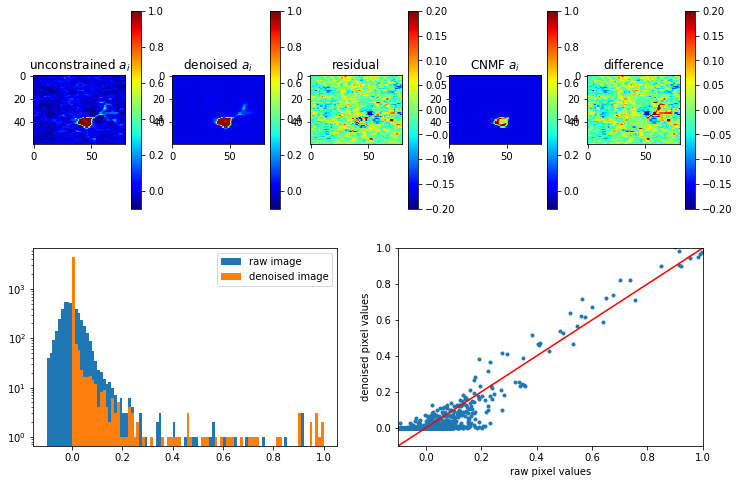

In [49]:
example_id = 3
img_raw, img_denoised = plot_2p_results(example_id, noise_level=0.2)

Text(0.5, 1.0, 'NN-denoiser')

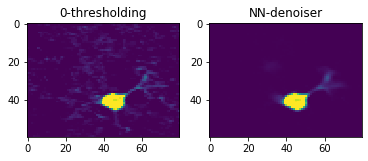

In [50]:
plt.subplot(121)
plt.imshow((img_raw * (img_raw>0)).squeeze(), clim=[0,1])
plt.title('0-thresholding')
plt.subplot(122)
plt.imshow(img_denoised.squeeze(), clim=[0,1])
plt.title('NN-denoiser')